In [210]:
#imports

from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import matplotlib
import os
import pickle
import random 
import operator
import math
import numpy as np
import os
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
from scipy.signal import blackman
from scipy.fft import fft, fftfreq

from miniesn_MBK import *
from numpy.random import randint, uniform, normal
import scipy.sparse as sparse
import scipy.sparse.linalg as sparse_linalg
import scipy.linalg as la

from scipy.integrate import trapz

# %matplotlib widget: make plots interactive
matplotlib.use('nbagg') 
# matplotlib.rcParams['figure.figsize']=(24,5)
matplotlib.rcParams['figure.figsize']=(20,4)

from tqdm import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# %load_ext jupyternotify

In [211]:
def calculate_onset(x=x, sr=sr):
    onset_env = librosa.onset.onset_strength(x, sr=sr, aggregate=np.median, hop_length = 512)
    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
    return onset_env, times

def tempo_and_beats(x=x, sr=sr):
    tempo, beats = librosa.beat.beat_track(y=x, sr=sr)
    return tempo, beats

def beat_times(x=x, sr=sr):
#     onset_env,_=calculate_onset(x, sr=sr)
    _,beats = tempo_and_beats(x, sr=sr)
    beattimes = np.zeros_like(onset_env)
    beattimes[beats]=1
    return beattimes

def separate_harmonic_and_rythmic(x=x, sr=sr):
    D = np.abs(librosa.stft(x))
    H,P=librosa.decompose.hpss(D)
    return H,P

def invert_spectrogram_to_audio(S):
    y=librosa.griffinlim(S)
    return y

def tempo_and_beats_harmonic(x=x,sr=sr):
    H,_ = separate_harmonic_and_rythmic(x, sr)
    y_harmonic = invert_spectrogram_to_audio(H)
    tempo_harmonic, beats_harmonic = tempo_and_beats(y_harmonic, sr)
    return tempo_harmonic, beats_harmonic

def tempo_and_beats_percussive(x=x,sr=sr):
    _,P = separate_harmonic_and_rythmic(x, sr)
    y_percussive = invert_spectrogram_to_audio(P)
    tempo_percussive, beats_percussive = tempo_and_beats(y_percussive, sr)
    return tempo_percussive, beats_percussive

def beat_times_harmonic(x=x, sr=sr):
    H,_ = separate_harmonic_and_rythmic(x, sr)
    y_harmonic = invert_spectrogram_to_audio(H)
    beattimes_harmonic = beat_times(y_harmonic, sr)
    return beattimes_harmonic

def beat_times_percussive(x=x, sr=sr):
    _,P = separate_harmonic_and_rythmic(x, sr)
    y_percussive = invert_spectrogram_to_audio(P)
    beattimes_percussive = beat_times(y_percussive, sr)
    return beattimes_percussive

def calc_onbeat(x=x, sr=sr):
    onset_env, times = calculate_onset(x, sr)
    beattimes = beat_times(x, sr)
    dt = times[1]-times[0]
    int_onset_env = trapz(onset_env, dx=dt)
    int_beattimes = trapz(beattimes,dx=dt)
    int_onset_env_onbeat = trapz(onset_env*beattimes, dx=dt)
    return int_onset_env_onbeat/(int_beattimes*int_onset_env)
 
def calc_onbeat_harmonic_percussive(x=x, sr=sr):
    H,P = separate_harmonic_and_rythmic(x=x, sr=sr)
    y_harmonic = invert_spectrogram_to_audio(H)
    y_percussive = invert_spectrogram_to_audio(P)
    onset_env_harmonic, times = calculate_onset(y_harmonic, sr)    
    onset_env_percussive, _ = calculate_onset(y_percussive, sr)
    beattimes_harmonic = beat_times_harmonic(x=x, sr=sr)
    beattimes_percussive = beat_times_percussive(x=x, sr=sr)
    
    int_onset_env_harmonic = trapz(onset_env_harmonic, dx=dt)
    int_beattimes_harmonic = trapz(beattimes_harmonic, dx=dt)
    int_onset_env_onbeat_harmonic = trapz(onset_env_harmonic*beattimes_harmonic, dx=dt)
    frac_onbeat_harmonic = int_onset_env_onbeat_harmonic/(int_beattimes_harmonic*int_onset_env_harmonic)
    
    int_onset_env_percussive = trapz(onset_env_percussive, dx=dt)
    int_beattimes_percussive = trapz(beattimes_percussive, dx=dt)
    int_onset_env_onbeat_percussive = trapz(onset_env_percussive*beattimes_percussive, dx=dt)
    frac_onbeat_percussive = int_onset_env_onbeat_percussive/(int_beattimes_percussive*int_onset_env_percussive)
    return frac_onbeat_harmonic, frac_onbeat_percussive
    

In [212]:
# dpath = r'C:\Users\MBK\OneDrive\Documents\uni\phd\AppliedMachineLearning2021\AppliedML2021\BigProject\audio\homemade'
genre_folder = os.path.join('music','genres')
genres = os.listdir(os.path.join(os.path.abspath(''),'..',genre_folder))
genres.remove('my.dat')

In [213]:
# ii=0
# song_id = []
# genre_data = []
# tempo_data = []
# tempo_harmonic_data = []
# tempo_percussive_data = []
# onbeat_data = []
# onbeat_harmonic_data = []
# onbeat_percussive_data = []
# for genre in genres:
#     dpath=os.path.abspath(os.path.join(os.path.abspath(''),'..',os.path.join(genre_folder,genre)))
#     print(dpath)
#     songs = os.listdir(dpath)
#     for song in songs:
#         if genre in song:
#             ii+=1
#             print('song %d of %d' %(ii, len(songs)))
#             x, sr = librosa.load(os.path.join(dpath, song))
#             onset_env = librosa.onset.onset_strength(x, sr=sr, aggregate=np.median, hop_length = 512)
#             times = librosa.times_like(onset_env, sr=sr, hop_length=512)
#             tempo, beats = librosa.beat.beat_track(y=x, sr=sr)
#             beattimes = np.zeros_like(onset_env)
#             beattimes[beats]=1
#             dt = times[1]-times[0]
#             onbeat = trapz(onset_env*beattimes, dx=dt)/( trapz(beattimes,dx=dt)*trapz(onset_env, dx=dt))
            
#             H,P=separate_harmonic_and_rythmic(x=x, sr=sr)
#             y_harmonic = invert_spectrogram_to_audio(H)
#             y_percussive = invert_spectrogram_to_audio(P)
#             onset_env_harmonic = librosa.onset.onset_strength(y_harmonic, sr=sr, aggregate=np.median, hop_length = 512)
#             onset_env_percussive = librosa.onset.onset_strength(y_percussive, sr=sr, aggregate=np.median, hop_length = 512)
#             tempo_harmonic, beats_harmonic = librosa.beat.beat_track(y=y_harmonic, sr=sr)
#             tempo_percussive, beats_percussive = librosa.beat.beat_track(y=y_percussive, sr=sr)
#             beattimes_harmonic = np.zeros_like(onset_env_harmonic)
#             beattimes_harmonic[beats_harmonic]=1
#             beattimes_percussive = np.zeros_like(onset_env_percussive)
#             beattimes_percussive[beats_percussive]=1
            
            
#             onbeat_harmonic = trapz(onset_env_harmonic*beattimes_harmonic, dx=dt)/( trapz(beattimes_harmonic,dx=dt)*trapz(onset_env_harmonic, dx=dt))
#             onbeat_percussive = trapz(onset_env_percussive*beattimes_percussive, dx=dt)/( trapz(beattimes_percussive,dx=dt)*trapz(onset_env_percussive, dx=dt))
            
            
# #             tempo, beats = tempo_and_beats(x=x, sr=sr)
# #             onbeat = calc_onbeat(x=x, sr=sr)
# #             tempo_harmonic,_ = tempo_and_beats_harmonic(x, sr)
# #             tempo_percussive,_ = tempo_and_beats_percussive(x, sr)
# #             onbeat_harmonic, onbeat_percussive = calc_onbeat_harmonic_percussive(x, sr)
            
#             genre_data.append(genre)
#             song_id.append(ii)
#             tempo_data.append(tempo)
#             onbeat_data.append(onbeat)
            
#             tempo_harmonic_data.append(tempo_harmonic)
#             tempo_percussive_data.append(tempo_percussive)
#             onbeat_harmonic_data.append(onbeat_harmonic)
#             onbeat_percussive_data.append(onbeat_percussive)
            
            
            

C:\Users\MBK\OneDrive\Documents\uni\phd\AppliedMachineLearning2021\ML2021BigProject\music\genres\blues
song 1 of 102
song 2 of 102
song 3 of 102
song 4 of 102
song 5 of 102
song 6 of 102
song 7 of 102
song 8 of 102
song 9 of 102
song 10 of 102
song 11 of 102
song 12 of 102
song 13 of 102
song 14 of 102
song 15 of 102
song 16 of 102
song 17 of 102
song 18 of 102
song 19 of 102
song 20 of 102
song 21 of 102
song 22 of 102
song 23 of 102
song 24 of 102
song 25 of 102
song 26 of 102
song 27 of 102
song 28 of 102
song 29 of 102
song 30 of 102
song 31 of 102
song 32 of 102
song 33 of 102
song 34 of 102
song 35 of 102
song 36 of 102
song 37 of 102
song 38 of 102
song 39 of 102
song 40 of 102
song 41 of 102
song 42 of 102
song 43 of 102
song 44 of 102
song 45 of 102
song 46 of 102
song 47 of 102
song 48 of 102
song 49 of 102
song 50 of 102
song 51 of 102
song 52 of 102
song 53 of 102
song 54 of 102
song 55 of 102
song 56 of 102
song 57 of 102
song 58 of 102
song 59 of 102
song 60 of 102
song 6

song 488 of 100
song 489 of 100
song 490 of 100
song 491 of 100
song 492 of 100
song 493 of 100
song 494 of 100
song 495 of 100
song 496 of 100
song 497 of 100
song 498 of 100
song 499 of 100
song 500 of 100
C:\Users\MBK\OneDrive\Documents\uni\phd\AppliedMachineLearning2021\ML2021BigProject\music\genres\jazz
song 501 of 100
song 502 of 100
song 503 of 100
song 504 of 100
song 505 of 100
song 506 of 100
song 507 of 100
song 508 of 100
song 509 of 100
song 510 of 100
song 511 of 100
song 512 of 100
song 513 of 100
song 514 of 100
song 515 of 100
song 516 of 100
song 517 of 100
song 518 of 100
song 519 of 100
song 520 of 100
song 521 of 100
song 522 of 100
song 523 of 100
song 524 of 100
song 525 of 100
song 526 of 100
song 527 of 100
song 528 of 100
song 529 of 100
song 530 of 100
song 531 of 100
song 532 of 100
song 533 of 100
song 534 of 100
song 535 of 100
song 536 of 100
song 537 of 100
song 538 of 100
song 539 of 100
song 540 of 100
song 541 of 100
song 542 of 100
song 543 of 100
so

song 969 of 100
song 970 of 100
song 971 of 100
song 972 of 100
song 973 of 100
song 974 of 100
song 975 of 100
song 976 of 100
song 977 of 100
song 978 of 100
song 979 of 100
song 980 of 100
song 981 of 100
song 982 of 100
song 983 of 100
song 984 of 100
song 985 of 100
song 986 of 100
song 987 of 100
song 988 of 100
song 989 of 100
song 990 of 100
song 991 of 100
song 992 of 100
song 993 of 100
song 994 of 100
song 995 of 100
song 996 of 100
song 997 of 100
song 998 of 100
song 999 of 100
song 1000 of 100


In [232]:
# print(onbeat_harmonic_data)
dataarray=np.array([np.array(song_id),np.array(genre_data),np.array(tempo_data),np.array(tempo_harmonic_data),np.array(tempo_percussive_data),np.array(onbeat_data),np.array(onbeat_harmonic_data),np.array(onbeat_percussive_data)]).T
dataDF = pd.DataFrame(dataarray, columns=['songID','genre','tempo','tempoHarmonic', 'tempoPercussive','onBeat','onBeatHarmonic','onBeatPercussive'])
# outputdata = pd.DataFrame(columns=np.array([np.array(song_id),np.array(genre_data),np.array(tempo_data),np.array(tempo_harmonic_data),np.array(tempo_percussive_data),np.array(onbeat_data),np.array(onbeat_harmonic_data),np.array(onbeat_percussive_data)]))
# outputdata
# np.array([np.array(song_id),np.array(genre_data),np.array(tempo_data),np.array(tempo_harmonic_data),np.array(tempo_percussive_data),np.array(onbeat_data),np.array(onbeat_harmonic_data),np.array(onbeat_percussive_data)])
dataarray
dataDF.to_csv('rythmic_data.csv',index=False)

In [170]:
desiredfolder=os.path.join('music','genres','disco')
dpath = os.path.abspath(os.path.join(os.path.abspath(''), '..', desiredfolder))
dfiles = os.listdir(dpath)

<IPython.core.display.Javascript object>


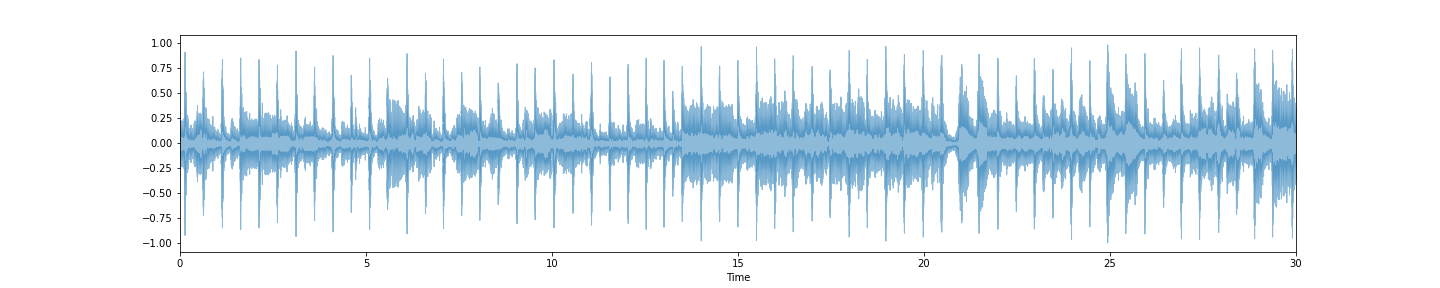

In [171]:
x, sr = librosa.load(os.path.join(dpath, dfiles[4]))
waveformTime = np.arange(start=0, stop=len(x)/sr, step=1/sr)
figwaveform=plt.figure('view waveform')
librosa.display.waveplot(x,alpha=.5)
figwaveform.show()
ipd.Audio(x, rate=sr)

In [172]:
D = np.abs(librosa.stft(x))
times = librosa.times_like(D)

In [133]:
# # Compute local onset autocorrelation
# hop_length = 512
# oenv = librosa.onset.onset_strength(y=x, sr=sr, hop_length=hop_length)
# tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
#                                       hop_length=hop_length)


In [134]:
tempo, beats = librosa.beat.beat_track(y=x, sr=sr)

In [135]:
onset_env = librosa.onset.onset_strength(x, sr=sr,
                                         aggregate=np.median)

<IPython.core.display.Javascript object>


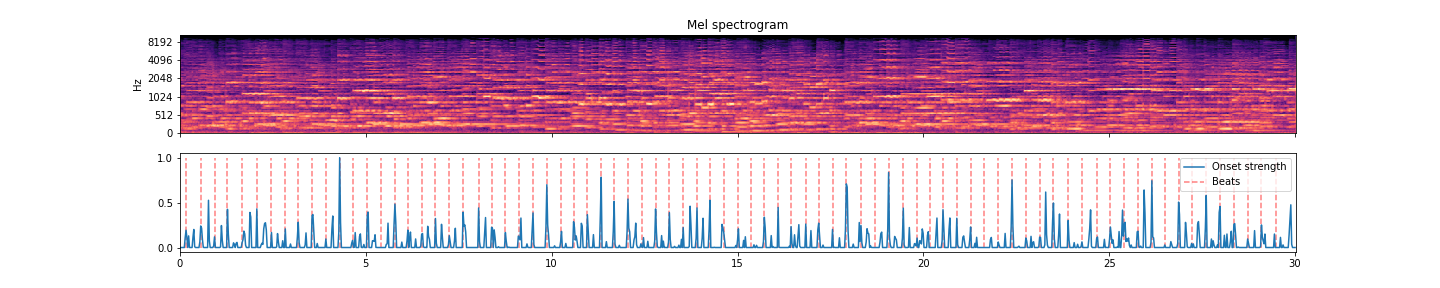

In [136]:
hop_length = 512
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
M = librosa.feature.melspectrogram(y=x, sr=sr, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[0])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
ax[1].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats')
ax[1].legend()

In [137]:
onset_env
beattimes = np.zeros_like(onset_env)
beattimes[beats]=1

In [138]:
beattimes

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

<IPython.core.display.Javascript object>


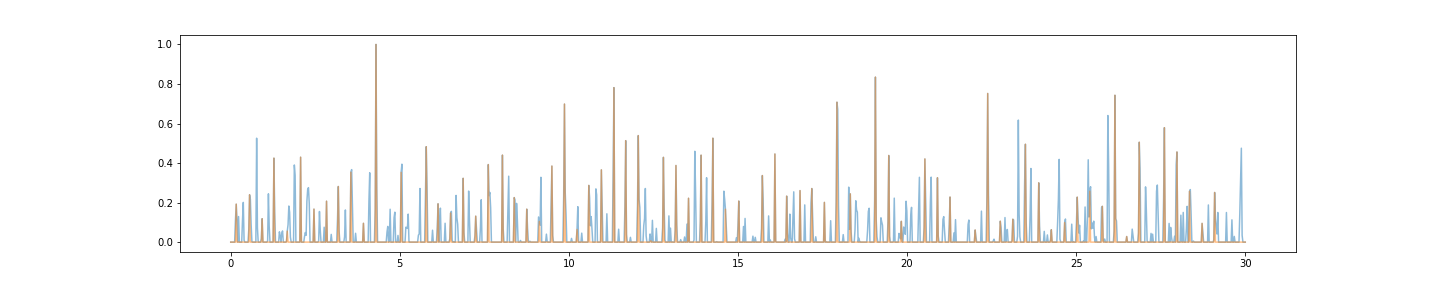

In [139]:
scaled_onset_env = librosa.util.normalize(onset_env)
plt.figure()
plt.clf()
plt.plot(times, scaled_onset_env,alpha=0.5)
plt.plot(times,scaled_onset_env*beattimes,alpha=0.5)

In [143]:
dt = times[1]-times[0]
int_onset_env = trapz(scaled_onset_env, dx=dt)
int_beattimes = trapz(beattimes,dx=dt)
int_onset_env_onbeat = trapz(scaled_onset_env*beattimes, dx=dt)

In [144]:
int_onset_env_onbeat/(int_beattimes*int_onset_env)

0.19121598

In [208]:
H,P=librosa.decompose.hpss(D)

<IPython.core.display.Javascript object>


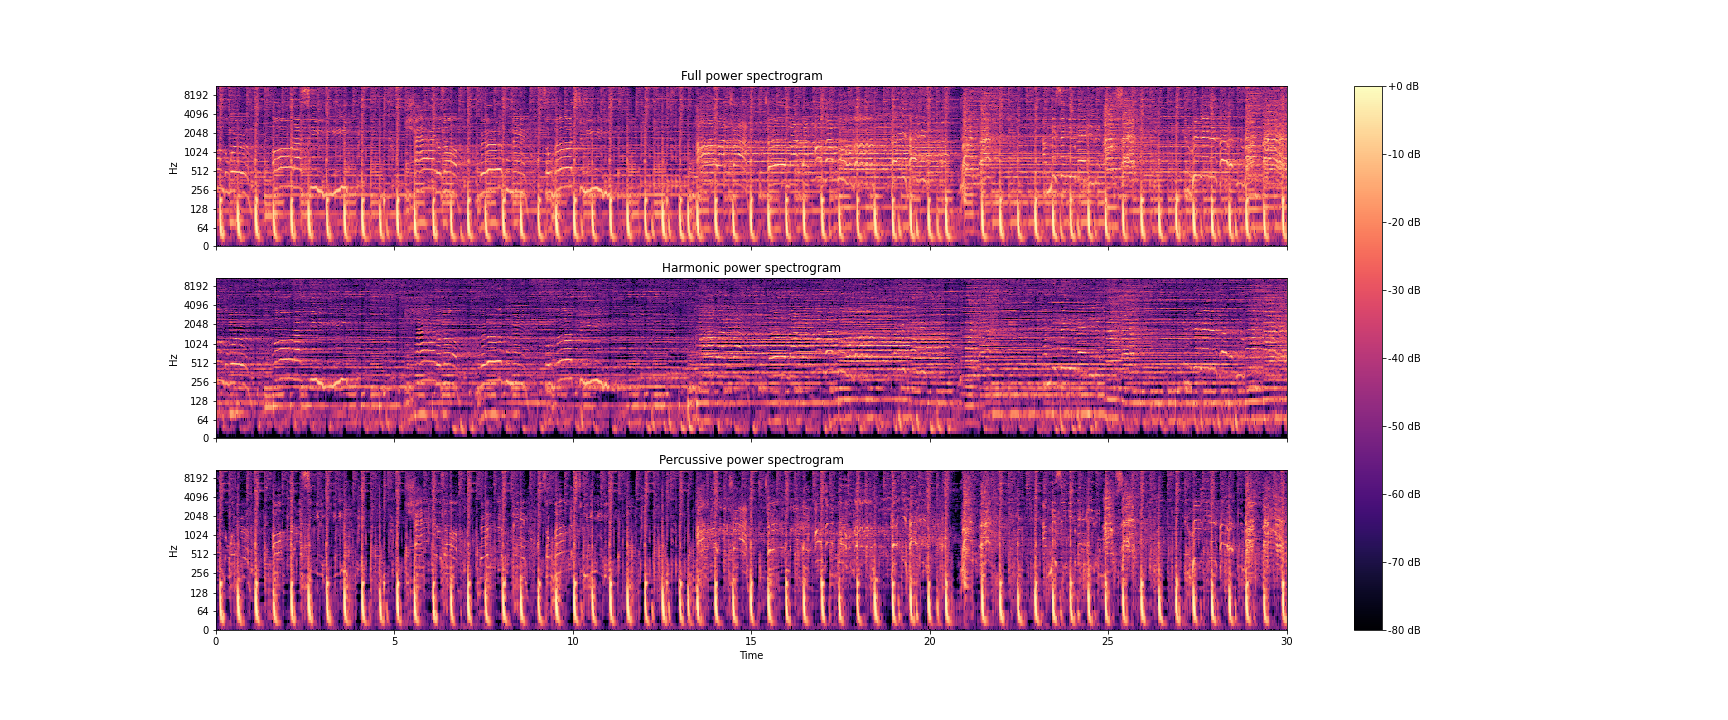

In [174]:
fig, ax = plt.subplots(figsize = (24,10),nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(D),
                                                       ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Full power spectrogram')
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(H),
                                                 ref=np.max(np.abs(D))),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Harmonic power spectrogram')
ax[1].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(P),
                                                 ref=np.max(np.abs(D))),
                         y_axis='log', x_axis='time', ax=ax[2])
ax[2].set(title='Percussive power spectrogram')
fig.colorbar(img, ax=ax, format='%+2.0f dB')

In [209]:
y = librosa.griffinlim(P)
ipd.Audio(y,rate=sr)

In [188]:
import tqdm